In [1]:
%matplotlib inline
import sklearn, tflearn, sys, os
import tensorflow as tf, os, csv, sqlite3, pandas as pd, numpy as np, codecs, re, traceback, math, pickle
import matplotlib.pyplot as plt
cpAry = ["D:/Python/Anaconda/notebook"]
[sys.path.insert(0, cp) for cp in cpAry if cp not in sys.path]

from contextlib import closing
from sklearn.utils import shuffle
from sklearn import metrics, preprocessing

exec(open("D:/Python/Anaconda/notebook/utils/utils.py").read())
base = reload("utils.base")
np.set_printoptions(precision=7, suppress=True, linewidth=200)

hdf5 is not supported on this machine (please install/reinstall h5py for optimal experience)
curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [3]:
ctxPath = 'D:/deeplearning/share/mp'

def connect():
    return sqlite3.connect('mp.sqlite')

class MpData:
    def __init__(self):
        self.data = {}
        self.yVal = 1.
        self.nVal = -1.
        self.scaler = preprocessing.StandardScaler()
    
    def queryBatch(self, sql, batch=2000):
        with closing(connect()) as conn, closing(conn.cursor()) as cur:
            cur.execute(sql)
            cache, cnt, cols = [], 0, None
            while True:
                r = cur.fetchone()
                if r is None:
                    break
                if cols is None:
                    cols = np.array(cur.description)[:, 0]
                    
                row_, r = [], np.array(r)
                for x, e in enumerate(r):
                    try:
                        row_.append(float(e))
                    except:
                        row_.append(1 if e == 'Y' else -1)
                cache.append(row_)
                if (cnt + 1) % batch == 0:
                    yield cols, np.array(cache)
                    del cache[:]
                cnt += 1
        if len(cache):
            yield cols, np.array(cache)
            del cache[:]
    
    def query(self, sql, scaler, norm=True):
        cache = []
        for cols, data in self.queryBatch(sql, batch=2000):
            cache.append(data)
        cache = np.vstack(cache)
        if norm:
            cache = np.c_[cache[:, 0], scaler.transform(cache[:, 1:-1]), cache[:, -1]]
        return cache

    def minibatches(self, key, isTrans=False, batch=100, shuffle=False):
        data = self.data[key] if isinstance(key, str) else key
        x, y = self.transform(data) if isTrans else data
        for idx in minibatchesIdx(len(x), batch, shuffle=shuffle):
            yield x[idx], y[idx]
            

def findData(date, targetTab):
    return pd.DataFrame(mp.query("""
        select * 
          from mp_{} a 
         where exists (select 1 
                         from {} b 
                        where a.subscr_id = b.subscr_id)""".format(date, targetTab), mp.scaler, norm=False))\
    .sort_values(0)\
    .reset_index(drop=True)
    
def iterData(data, batch, epLim=1):
    if type(data) in (tuple, list):
        x, y = data
        idAry = minibatchesIdx(len(x), batch)
        # print(len(idAry), idAry[-1])
        epCnt = 0
        while True:
            if epLim is not None and epCnt >= epLim: break
            for idx in idAry:
                yield x[idx], y[idx]
            epCnt += 1

In [4]:
class CnnModel(base.Model):
    def graphing(self, sess):
        self.history = {}
        with tf.name_scope("inputs") as scope:
            self.x_ = tf.placeholder(tf.float32, [None, 167, 4, 1], name="x_")
            self.y_ = tf.placeholder(tf.float32, [None, 2], name="y_")
            self.keepProp = tf.placeholder(tf.float32, name="keepProp")
        #  x, nFilter, fShape, name, padding="SAME", actv=None, actvName=None
        net = self.convLayer(self.x_, 4, [2, 1], "conv1", padding="VALID", actv=tf.nn.relu)
        net = self.convLayer(net, 12, [4, 1], "conv2", padding="VALID", actv=tf.nn.relu)
        
        net = self.addLayer(net, 64, "fc1", actv=tf.nn.softplus)
        self.logits = self.addLayer(net, 2, "output")
        self.pred = tf.nn.softmax(self.logits, name='pred')
        # tf.histogram_summary("pred", self.pred)
        
        with tf.name_scope("loss") as scope:
            # self.loss = -tf.reduce_sum(self.y_ * tf.log(self.pred + 1e-10), name="cross_entropy")
            # self.loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(self.logits, self.y_), name="loss")
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.logits, labels=self.y_), name="loss")
            # 加上 l2 regularization
            # beta = 0.01
            # for p in self.params:
            #     self.loss += beta * tf.nn.l2_loss(p['w']) + beta * tf.nn.l2_loss(p['b'])
            # tf.scalar_summary("loss", self.loss)
            
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.01, name="Adam").minimize(self.loss)
        with tf.name_scope("test") as scope:
            correct_prediction = tf.equal(tf.argmax(self.pred, 1), tf.argmax(self.y_, 1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')
            # accuracy_summ = tf.scalar_summary("accuracy", self.accuracy)
        # save the graph
        self.graph = sess.graph
        return self
    
    def weight_variable(self, shape):
        initial = tf.random_uniform(shape, minval=0)
        # initial = tf.uniform_unit_scaling_initializer(shape, stddev=0.02, dtype=tf.float32)
        return tf.Variable(initial)

# prepare data

In [5]:
mp = MpData()
# mp.scaler = loadVar('/'.join([ctxPath, 'scaler_mp_201508.pkl']))

In [ ]:
# tr = mp.query("""select * from mp_201508""", mp.scaler)
# trX, trY = tr[:, 1:-1], np.array([[0., 1.] if e == 1 else [1., 0.] for e in tr[:, -1]])
# trX.shape, trY.shape

In [ ]:
# te = mp.query("""select * from mp_201605""", mp.scaler)
# teX, teY = te[:, 1:-1], np.array([[0., 1.] if e == 1 else [1., 0.] for e in te[:, -1]])
# teX.shape, teY.shape

+ 資料加上時間軸

In [6]:
trlist = (findData('201507', 'train_subs'), findData('201508', 'train_subs'), findData('201509', 'train_subs'), findData('201510', 'train_subs'))
trX = np.stack((trlist[-1].iloc[:, 1:-1].values, trlist[-2].iloc[:, 1:-1].values, trlist[-3].iloc[:, 1:-1].values, trlist[-4].iloc[:, 1:-1].values), 2)
trY = np.array([[0., 1.] if e == 1 else [1., 0.] for e in trlist[-1].iloc[:, -1]])

In [7]:
telist = (findData('201603', 'test_subs'), findData('201604', 'test_subs'), findData('201605', 'test_subs'), findData('201606', 'test_subs'))
teX = np.stack((telist[-1].iloc[:, 1:-1].values, telist[-2].iloc[:, 1:-1].values, telist[-3].iloc[:, 1:-1].values, telist[-4].iloc[:, 1:-1].values), 2)
teY = np.array([[0., 1.] if e == 1 else [1., 0.] for e in telist[-1].iloc[:, -1]])

In [8]:
scaler = preprocessing.StandardScaler()
scaler.fit(trX[:, :, 0])
for i in range(4):
    trX[:, :, i] = scaler.transform(trX[:, :, i])
    teX[:, :, i] = scaler.transform(teX[:, :, i])

In [9]:
trX.shape, trY.shape, teX.shape, teY.shape

((100000, 164, 4), (100000, 2), (100000, 164, 4), (100000, 2))

+ 加上 mp nes 變數, subscr_id會減少

In [10]:
# 加上3個欄位: [NES, 當月消費次數, 當月消費金額]
def appendNes(subids, x, y, monthes, mode):
    with closing(connect()) as conn:
        subIdSet = set()
        queue = []
        for i, month in enumerate(monthes, 1):
            sql = """
                select *
                  from mp_nes_by_month_{} a
                 where exists (select 1 from {}
                                where subscr_id = a.subscr_id)
            """.format(month, "train_subs" if mode == "train" else "test_subs")
            df = pd.read_sql(sql, conn).astype(np.float64, copy=False).sort_values("SUBSCR_ID")
            queue.append(df)
            subIdSet.intersection_update(df["SUBSCR_ID"]) if i > 1 else subIdSet.update(df["SUBSCR_ID"])

    for i in range(len(queue)):
        df = queue[i]
        queue[i] = df[df["SUBSCR_ID"].isin(subIdSet)].drop("SUBSCR_ID", axis=1).values
    # nesStack = np.stack(tuple(e for e in queue), 2)
    
    conds = subids.isin(subIdSet).values
    retX = np.stack(tuple(np.c_[x[conds][:, :, i], queue[i]] for i in range(x.shape[2])), 2)
    return retX, y[conds], conds
    
trNesX, trNesY, trNesConds = appendNes(trlist[-1].iloc[:, 0], trX, trY, ("201510", "201509", "201508", "201507"), "train")
teNesX, teNesY, teNesConds = appendNes(telist[-1].iloc[:, 0], teX, teY, ("201606", "201605", "201604", "201603"), "test")

# normalize train test data
nesScaler = preprocessing.StandardScaler()
nesScaler.fit(trNesX[:, :, 0])
for i in range(4):
    trNesX[:, :, i] = nesScaler.transform(trNesX[:, :, i])
    teNesX[:, :, i] = nesScaler.transform(teNesX[:, :, i])

In [17]:
trNesX.shape, trNesY.shape, teNesX.shape, teNesY.shape

((86701, 167, 4), (86701, 2), (92391, 167, 4), (92391, 2))

## keras cnn

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, MaxPooling2D, Conv2D, MaxPooling1D
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
from contextlib import closing
from sklearn.utils import shuffle
from sklearn import metrics, preprocessing

In [15]:
from keras.backend import tensorflow_backend as tfbk
def buildModel(shape):
    tfbk.reset_uids()
    model = Sequential()
    model.add(Conv1D(4, 2, input_shape=shape))
    model.add(Activation('relu'))
    model.add(Conv1D(12, 4))
    model.add(Activation('relu'))
    # model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('softplus'))
    # model.add(Dropout(0.5))
    model.add(Dense(2))
    model.add(Activation('softmax'))

    '''setting optimizer'''
    learning_rate = 0.001
    optimizer = Adam(learning_rate)
    # sgd = SGD(lr=learning_rate, decay=learning_decay, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    # check parameters of every layers
    model.summary()
    return model

def buildNesModel(shape):
    return buildModel(shape)

def train(model, trX, trY, teX, teY):
    batch, nEpoch = 200, 5
    fit_log = model.fit_generator(iterData((trX, trY), batch=batch, epLim=nEpoch + 1), 
                                  samples_per_epoch=trX.shape[0], nb_epoch=nEpoch)
    trPred = model.predict(trX)
    rpt(trY, trPred, 'train')

    tePred = model.predict(teX)
    rpt(teY, tePred, 'test')
    
    return fit_log


+ cnn without nes, conv1d

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution1d_1 (Convolution1D)  (None, 163, 4)        36          convolution1d_input_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 163, 4)        0           convolution1d_1[0][0]            
____________________________________________________________________________________________________
convolution1d_2 (Convolution1D)  (None, 160, 12)       204         activation_1[0][0]               
____________________________________________________________________________________________________
activation_2 (Activation)        (None, 160, 12)       0           convolution1d_2[0][0]            
___________________________________________________________________________________________

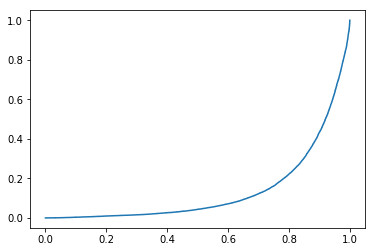


test
-------------------------------------------------------
       0      1
0  27510  10429
1  11074  43378
             precision    recall  f1-score   support

          0       0.71      0.73      0.72     37939
          1       0.81      0.80      0.80     54452

avg / total       0.77      0.77      0.77     92391

gini coef: 0.6851529956882325


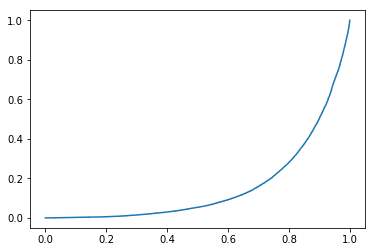

In [18]:
model1d = buildModel(trX[trNesConds][0].shape)
train(model1d, trX[trNesConds], trY[trNesConds], teX[teNesConds], teY[teNesConds])

+ cnn add nes variables, conv1d

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution1d_1 (Convolution1D)  (None, 166, 4)        36          convolution1d_input_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 166, 4)        0           convolution1d_1[0][0]            
____________________________________________________________________________________________________
convolution1d_2 (Convolution1D)  (None, 163, 12)       204         activation_1[0][0]               
____________________________________________________________________________________________________
activation_2 (Activation)        (None, 163, 12)       0           convolution1d_2[0][0]            
___________________________________________________________________________________________

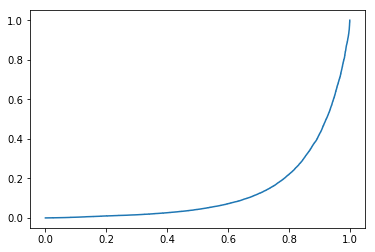


test
-------------------------------------------------------
       0      1
0  27049  10890
1  10554  43898
             precision    recall  f1-score   support

          0       0.72      0.71      0.72     37939
          1       0.80      0.81      0.80     54452

avg / total       0.77      0.77      0.77     92391

gini coef: 0.6882818957270693


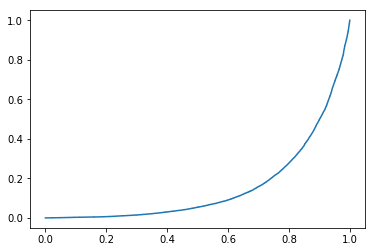

In [19]:
nesModel1d = buildNesModel(trNesX[0].shape)
train(nesModel1d, trNesX, trNesY, teNesX, teNesY)

+ cnn add nes variables, conv2d

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 167, 4, 4)     20          convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 167, 4, 4)     0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 1, 4, 12)      8028        activation_1[0][0]               
____________________________________________________________________________________________________
activation_2 (Activation)        (None, 1, 4, 12)      0           convolution2d_2[0][0]            
___________________________________________________________________________________________

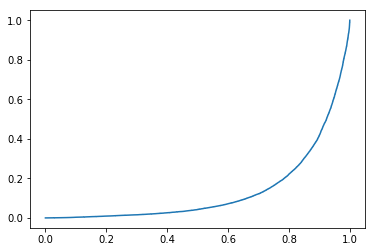


test
-------------------------------------------------------
       0      1
0  27267  10672
1  10732  43720
             precision    recall  f1-score   support

          0       0.72      0.72      0.72     37939
          1       0.80      0.80      0.80     54452

avg / total       0.77      0.77      0.77     92391

gini coef: 0.6900618740015111


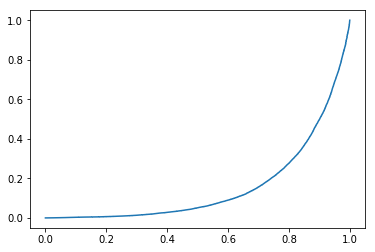

In [20]:
def buildNesModel2D(shape):
    tfbk.reset_uids()
    model = Sequential()
    model.add(Conv2D(4, 1, 4, border_mode="same", input_shape=shape))
    model.add(Activation('relu'))
    model.add(Conv2D(12, 167, 1))
    model.add(Activation('relu'))
    # model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('softplus'))
    # model.add(Dropout(0.5))
    model.add(Dense(2))
    model.add(Activation('softmax'))

    '''setting optimizer'''
    learning_rate = 0.001
    optimizer = Adam(learning_rate)
    # sgd = SGD(lr=learning_rate, decay=learning_decay, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    # check parameters of every layers
    model.summary()
    return model

nesModel2D = buildNesModel2D((167, 4, 1))
train(nesModel2D, trNesX.reshape(-1, 167, 4, 1), trNesY, teNesX.reshape(-1, 167, 4, 1), teNesY)

# feature selection

In [21]:
with closing(connect()) as conn:
    meta = pd.read_sql('select * from mp_meta', conn)
# 加上變數 [nes, 當月消費次數, 當月消費金額]

meta = meta.append([{"col_name": "NES", "dscr": "NES變數", "var_type": "彙總"},
                    {"col_name": "N_PAY", "dscr": "當月消費次數", "var_type": "彙總"},
                    {"col_name": "AMT", "dscr": "當月消費金額", "var_type": "彙總"}], ignore_index=True)
meta = meta.ix[1:164, :].append(meta.ix[166:, :], ignore_index=True)
meta

,idx,var_type,col_name,dscr,logic,if_null
0,2.0,原始,LST1_CNT_BM,最近一個月月租銷貨次數,None,NULL補0
1,3.0,原始,LST1_CNT_BT,最近一個月計次銷貨次數,None,NULL補0
2,4.0,原始,LST1_CNT_FLUR,最近一個月失敗銷貨次數,None,NULL補0
3,5.0,原始,LST1_CNT_FLUR_UNDR_ACCT,最近一個月額度不足失敗銷貨次數,None,NULL補0
4,6.0,原始,LST1_CNT_FLUR_UPON_ACCT,最近一個月非額度不足失敗銷貨次數,None,NULL補0
5,7.0,原始,LST1_CNT_SCCESS,最近一個月成功銷貨次數,None,NULL補0
6,8.0,原始,LST1_GG_CNT,最近一個月GOOGLE銷貨次數,None,NULL補0
7,9.0,原始,LST1_GG_CNT_FLUR,最近一個月GOOGLE失敗銷貨次數,None,NULL補0
8,10.0,原始,LST1_GG_CNT_FLUR_UNDR_ACCT,最近一個月GOOGLE額度不足失敗銷貨次數,None,NULL補0
9,11.0,原始,LST1_GG_CNT_FLUR_UPON_ACCT,最近一個月GOOGLE非額度不足失敗銷貨次數,None,NULL補0


## 隨機森林為基礎的feature selection

In [22]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
clf = ExtraTreesClassifier(n_estimators=100, bootstrap=True, n_jobs=4)
clf = clf.fit(trNesX[:, :, 0], np.argmax(trNesY, 1))
# print(clf.feature_importances_)

# sfm = SelectFromModel(clf, prefit=True)
f = pd.Series(clf.feature_importances_)
f = f[f > f[f != 0].mean()]
f.sort_values(ascending=False, inplace=True)

meta1 = meta.ix[f.index, ["var_type", "col_name", "dscr"]]
meta1.ix[:, "importance_coef"] = f.values
print(len(meta1))
meta1

43


,var_type,col_name,dscr,importance_coef
134,原始,LSTD_TXN_SCCESS,最後成功銷貨距今天數,0.049794
130,原始,LSTD_TXN_BT,最後計次銷貨距今天數,0.045485
164,彙總,NES,NES變數,0.044827
159,彙總,LSTM_RF_HCNT_BM,最近六個月最高月租銷退次數距今月份數,0.030863
140,彙總,LSTM_GG_RF_HCNT,最近六個月最高GOOGLE銷退次數距今月份數,0.029884
117,原始,LSTD_GG_TXN,最後GOOGLE銷貨距今天數,0.027075
87,彙總,LST6_MNY,最近六個月平均銷貨金額,0.026465
89,彙總,LST6_MNY_BT,最近六個月平均計次銷貨金額,0.025861
84,彙總,LST6_HMNY,最近六個月最高銷貨金額,0.023828
86,彙總,LST6_HMNY_BT,最近六個月最高計次銷貨金額,0.023465


# pure tensorflow training

epoch 1/5, count: [19800/86701], trAccu: 0.8050, trLoss: 0.4501, phaseAccu: 0.7373, phaseLoss: 0.5312
epoch 1/5, count: [39800/86701], trAccu: 0.7950, trLoss: 0.4544, phaseAccu: 0.7631, phaseLoss: 0.4824
epoch 1/5, count: [59800/86701], trAccu: 0.7550, trLoss: 0.4872, phaseAccu: 0.7666, phaseLoss: 0.4779
epoch 1/5, count: [79800/86701], trAccu: 0.7450, trLoss: 0.5015, phaseAccu: 0.7806, phaseLoss: 0.4691
epoch 1/5, count: [86701/86701], trAccu: 0.8317, trLoss: 0.4533
epoch 2/5, count: [19800/86701], trAccu: 0.8150, trLoss: 0.4374, phaseAccu: 0.7839, phaseLoss: 0.4746
epoch 2/5, count: [39800/86701], trAccu: 0.8050, trLoss: 0.4213, phaseAccu: 0.7866, phaseLoss: 0.4594
epoch 2/5, count: [59800/86701], trAccu: 0.7650, trLoss: 0.4790, phaseAccu: 0.7873, phaseLoss: 0.4572
epoch 2/5, count: [79800/86701], trAccu: 0.7700, trLoss: 0.4705, phaseAccu: 0.7865, phaseLoss: 0.4598
epoch 2/5, count: [86701/86701], trAccu: 0.8317, trLoss: 0.4642
epoch 3/5, count: [19800/86701], trAccu: 0.8050, trLoss:

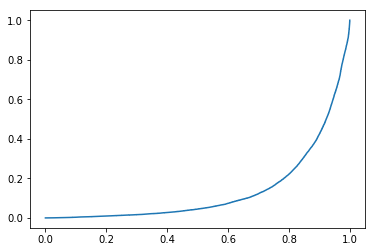

ValueError: Cannot feed value of shape (100000, 164, 4) for Tensor 'inputs/x_:0', which has shape '(?, 167, 4, 1)'

In [58]:
%%time
def trainTf(m, trX, trY, teX, teY):
    namespace = 'puretf'
    ctx = '/'.join(['cnn', namespace])
    outfname = '/'.join([ctx, 'cnn_mp_model.ckpt'])
    historyPath = '/'.join([ctx, 'cnn_mp_model_history.pkl'])
    logdir = '/'.join(['logs/cnn', namespace])
    try:
        if not os.path.exists(ctx): os.makedirs(ctx)
        os.unlink(outfname)
    except:
        pass

    tf.reset_default_graph()
    with tf.Graph().as_default(), tf.Session() as sess:
        with tf.device("/cpu:0"):
            m.graphing(sess)
            tf.global_variables_initializer().run()        
            m.fit((trX, trY), sess, epoch=5, batch=200)

            saver = tf.train.Saver()
            m.save(sess, outfname, saver)
            with open(historyPath, 'wb') as w:
                pickle.dump(m.history, w)

            accu, trPred, _ = sess.run([m.accuracy, m.pred, tf.no_op()], feed_dict={m.x_: trX, m.y_: trY, m.keepProp: 1.})
            rpt(trY, trPred, 'train')

            accu, tePred, _ = sess.run([m.accuracy, m.pred, tf.no_op()], feed_dict={m.x_: teX, m.y_: teY, m.keepProp: 1.})
            rpt(teY, tePred, 'test')

            showHistory(m)
        
trainTf(CnnModel(), trNesX.reshape(-1, 167, 4, 1), trNesY, teNesX.reshape(-1, 167, 4, 1), teY)

+ load pretrained model

In [59]:
?tf.train.import_meta_graph

train
-------------------------------------------------------
       0      1
0  23039   8428
1   9428  45806
             precision    recall  f1-score   support

          0       0.71      0.73      0.72     31467
          1       0.84      0.83      0.84     55234

avg / total       0.80      0.79      0.79     86701

gini coef: 0.728566691747558


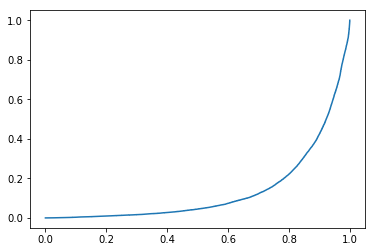


test
-------------------------------------------------------
       0      1
0  27701  10238
1  11276  43176
             precision    recall  f1-score   support

          0       0.71      0.73      0.72     37939
          1       0.81      0.79      0.80     54452

avg / total       0.77      0.77      0.77     92391

gini coef: 0.684784960075609


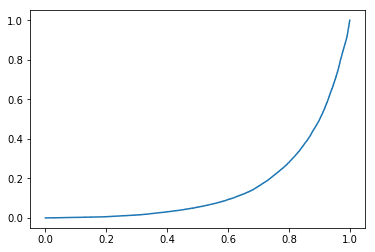

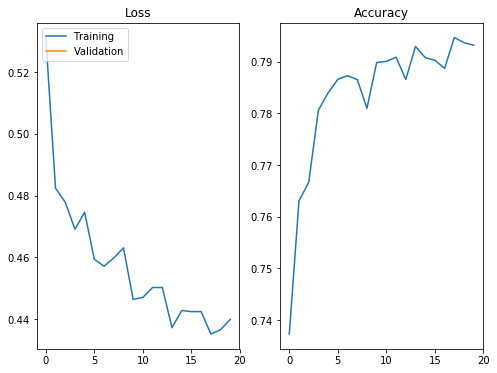

In [63]:
def loadPretrained(trX, trY, teX, teY):
    namespace = 'puretf'
    ctx = '/'.join(['cnn', namespace])
    outfname = '/'.join([ctx, 'cnn_mp_model.ckpt'])
    historyPath = '/'.join([ctx, 'cnn_mp_model_history.pkl'])
    logdir = '/'.join(['logs/cnn', namespace])

    tf.reset_default_graph()
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        model = CnnModel()
        saver = tf.train.import_meta_graph('{}.meta'.format(outfname))
        saver.restore(sess, outfname)
        model.x_ = sess.graph.get_tensor_by_name('inputs/x_:0')
        model.y_ = sess.graph.get_tensor_by_name('inputs/y_:0')
        model.pred = sess.graph.get_tensor_by_name('pred:0')
        model.accuracy = sess.graph.get_tensor_by_name('test/accuracy:0')
        model.loss = sess.graph.get_tensor_by_name('loss/loss:0')
        model.graph = sess.graph
        # for n in sess.graph.as_graph_def().node:
        #     print(n.name)
        with open(historyPath, 'rb') as r:
            model.history = pickle.load(r)

        # train data
        trPred, _ = sess.run([model.pred, tf.no_op()], feed_dict={model.x_: trX, model.y_: trY})
        rpt(trY, trPred, 'train')

        # test data
        tePred, _ = sess.run([model.pred, tf.no_op()], feed_dict={model.x_: teX, model.y_: teY})
        rpt(teY, tePred, 'test')
    showHistory(model)
    
loadPretrained(trNesX.reshape(-1, 167, 4, 1), trNesY, teNesX.reshape(-1, 167, 4, 1), teNesY)

# tflearn cnn

+ conv1d

Training Step: 2170  | total loss: 0.43072 | time: 3.837s
| Adam | epoch: 005 | loss: 0.43072 - acc: 0.7952 -- iter: 86701/86701
train
-------------------------------------------------------
       0      1
0  20340  11127
1  12132  43102
             precision    recall  f1-score   support

          0       0.63      0.65      0.64     31467
          1       0.79      0.78      0.79     55234

avg / total       0.73      0.73      0.73     86701

gini coef: 0.5509243339902208


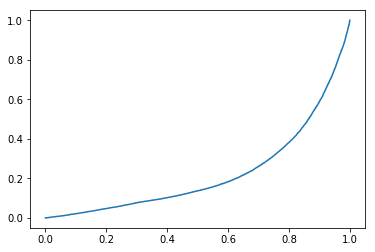


test
-------------------------------------------------------
       0      1
0  24314  13625
1  14334  40118
             precision    recall  f1-score   support

          0       0.63      0.64      0.63     37939
          1       0.75      0.74      0.74     54452

avg / total       0.70      0.70      0.70     92391

gini coef: 0.4895668650666416


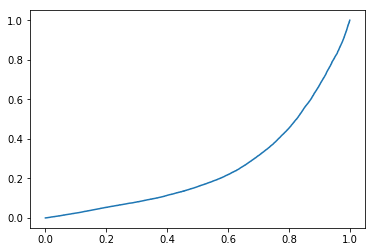


Wall time: 32.3 s


In [19]:
%%time
def tflearnTrain1D(inputShape, trX, trY, teX, teY):
    k = 'train'
    ctx = '/'.join(['cnn', k])
    outfname = '/'.join([ctx, 'cnn_mp_model1d.ckpt'])
    historyPath = '/'.join([ctx, 'cnn_mp_model1d_history.pkl'])
    logdir = '/'.join(['logs/cnn', k])
    try:
        if not os.path.exists(ctx):
            os.makedirs(ctx)
        os.unlink(outfname)
    except:
        pass

    tf.reset_default_graph()
    with tf.Graph().as_default():
        net = tflearn.input_data(shape=inputShape, name='inputs')
        net = tflearn.conv_1d(net, 4, 2, padding='valid', activation='relu')
        net = tflearn.conv_1d(net, 12, 4, padding='valid', activation='relu')
        # net = tflearn.conv_1d(net, 16, 5, padding='valid', activation='relu')
        # net = tflearn.avg_pool_1d(net, 3, padding='same')
        # print(net)
        net = tflearn.fully_connected(net, 64, activation='softplus', name='fc1')
        net = tflearn.fully_connected(net, 2, activation="softmax", name='outputs')
        net = tflearn.regression(net, optimizer="adam", learning_rate=0.001, loss="categorical_crossentropy", batch_size=200, name='target')

        # training
        model = tflearn.DNN(net, tensorboard_verbose=0, tensorboard_dir=logdir)
        model.fit(trX, trY, n_epoch=5, snapshot_epoch=False, show_metric=True, run_id="cnn1d_with_time_axis")

        trPred = model.predict(trX)
        rpt(trY, np.array(trPred, dtype=np.float32), "train")

        tePred = model.predict(teX)
        rpt(teY, np.array(tePred, dtype=np.float32), "test")
        return model
        
tfmodel1d = tflearnTrain1D((None, 164, 4), trX[trNesConds], trY[trNesConds], teX[teNesConds], teY[teNesConds])

+ conv2d (gpu版本狂炸記憶體)

In [43]:
def tflearnTrain2D(inputShape, trX, trY, teX, teY):
    k = 'train'
    ctx = '/'.join(['cnn', k])
    outfname = '/'.join([ctx, 'cnn_mp_model2d.ckpt'])
    historyPath = '/'.join([ctx, 'cnn_mp_model2d_history.pkl'])
    logdir = '/'.join(['logs/cnn', k])

    try:
        if not os.path.exists(ctx):
            os.makedirs(ctx)
        os.unlink(outfname)
    except:
        pass

    tf.reset_default_graph()
    with tf.Graph().as_default():
        net = tflearn.input_data(shape=inputShape, name='inputs')
        net = tflearn.conv_2d(net, 4, [2, 1], padding='valid', activation='relu', name="conv1")
        # print(net)
        net = tflearn.conv_2d(net, 4, [4, 1], padding='valid', activation='relu', name="conv2")
        # net = tflearn.merge([b1, b2, b3], "concat", axis=3)
        # print(net)
        # net = tflearn.conv_2d(net, 4, 8, padding='same', activation='relu')
        # net = tflearn.max_pool_2d(net, 3, padding='same')
        # print(net)
        net = tflearn.fully_connected(net, 64, activation='relu', name='fc1')
        net = tflearn.fully_connected(net, 2, activation='softmax', name='outputs')
        net = tflearn.regression(net, optimizer="adam", learning_rate=0.01, loss="categorical_crossentropy", batch_size=200, name='target')
        # training
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        with tf.Session(config=config) as sess:
            model = tflearn.DNN(net, tensorboard_verbose=0, tensorboard_dir=logdir, session=sess)
            tf.global_variables_initializer().run()
            model.fit(trX, trY, n_epoch=5, snapshot_epoch=False, show_metric=True, run_id="cnn2d_with_time_axis")

            trPred = model.predict(trX)
            rpt(trY, np.array(trPred, dtype=np.float32), "train")

            tePred = model.predict(teX)
            rpt(teY, np.array(tePred, dtype=np.float32), "test")
        return model
    
tfmodel2d = tflearnTrain2D((None, 164, 4, 1), trX[trNesConds].reshape(-1, 164, 4, 1), trY[trNesConds], teX[teNesConds].reshape(-1, 164, 4, 1), teY[teNesConds])

Training Step: 2170  | total loss: 0.43029 | time: 6.367s
| Adam | epoch: 005 | loss: 0.43029 - acc: 0.8042 -- iter: 86701/86701


ResourceExhaustedError: OOM when allocating tensor with shape[86701,4,160,4]
	 [[Node: conv2/Conv2D = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](conv1/Relu, conv2/W/read)]]

Caused by op 'conv2/Conv2D', defined at:
  File "D:\Python\Anaconda\Anaconda2\envs\tensorflow-gpu\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "D:\Python\Anaconda\Anaconda2\envs\tensorflow-gpu\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "D:\Python\Anaconda\Anaconda2\envs\tensorflow-gpu\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "D:\Python\Anaconda\Anaconda2\envs\tensorflow-gpu\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "D:\Python\Anaconda\Anaconda2\envs\tensorflow-gpu\lib\site-packages\ipykernel\kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "D:\Python\Anaconda\Anaconda2\envs\tensorflow-gpu\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "D:\Python\Anaconda\Anaconda2\envs\tensorflow-gpu\lib\site-packages\tornado\ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "D:\Python\Anaconda\Anaconda2\envs\tensorflow-gpu\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "D:\Python\Anaconda\Anaconda2\envs\tensorflow-gpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "D:\Python\Anaconda\Anaconda2\envs\tensorflow-gpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "D:\Python\Anaconda\Anaconda2\envs\tensorflow-gpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "D:\Python\Anaconda\Anaconda2\envs\tensorflow-gpu\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "D:\Python\Anaconda\Anaconda2\envs\tensorflow-gpu\lib\site-packages\ipykernel\kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "D:\Python\Anaconda\Anaconda2\envs\tensorflow-gpu\lib\site-packages\ipykernel\kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "D:\Python\Anaconda\Anaconda2\envs\tensorflow-gpu\lib\site-packages\ipykernel\kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "D:\Python\Anaconda\Anaconda2\envs\tensorflow-gpu\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "D:\Python\Anaconda\Anaconda2\envs\tensorflow-gpu\lib\site-packages\ipykernel\zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "D:\Python\Anaconda\Anaconda2\envs\tensorflow-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "D:\Python\Anaconda\Anaconda2\envs\tensorflow-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "D:\Python\Anaconda\Anaconda2\envs\tensorflow-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-43-69a4c513a2bd>", line 44, in <module>
    tfmodel2d = tflearnTrain2D((None, 164, 4, 1), trX[trNesConds].reshape(-1, 164, 4, 1), trY[trNesConds], teX[teNesConds].reshape(-1, 164, 4, 1), teY[teNesConds])
  File "<ipython-input-43-69a4c513a2bd>", line 20, in tflearnTrain2D
    net = tflearn.conv_2d(net, 4, [4, 1], padding='valid', activation='relu', name="conv2")
  File "D:\Python\Anaconda\Anaconda2\envs\tensorflow-gpu\lib\site-packages\tflearn\layers\conv.py", line 98, in conv_2d
    inference = tf.nn.conv2d(incoming, W, strides, padding)
  File "D:\Python\Anaconda\Anaconda2\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 396, in conv2d
    data_format=data_format, name=name)
  File "D:\Python\Anaconda\Anaconda2\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "D:\Python\Anaconda\Anaconda2\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "D:\Python\Anaconda\Anaconda2\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[86701,4,160,4]
	 [[Node: conv2/Conv2D = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](conv1/Relu, conv2/W/read)]]


In [79]:
tf.reset_default_graph()
with tf.Graph().as_default():
    net = tflearn.input_data(shape=[None, 164, 4, 1], name='inputs')
    net = tflearn.conv_2d(net, 16, [164, 1], padding='valid', activation='relu')
    net = tflearn.conv_2d(net, 164, [1, 4], padding='valid', activation='relu')
    # net = tflearn.merge([b1, b2, b3], "concat", axis=3)
    print(net)
    # net = tflearn.conv_2d(net, 4, 8, padding='same', activation='relu')
    # net = tflearn.max_pool_2d(net, 3, padding='same')
    # print(net)
    
    net = tflearn.fully_connected(net, 64, activation='relu', name='fc1')
    net = tflearn.fully_connected(net, 2, activation='softmax', name='outputs')
    net = tflearn.regression(net, optimizer="adam", learning_rate=0.01, loss="categorical_crossentropy", batch_size=256, name='target')
    
    # training
    model2d = tflearn.DNN(net, tensorboard_verbose=0, tensorboard_dir=logdir)
    model2d.fit(trX.reshape(-1, 164, 4, 1), trY, n_epoch=10, snapshot_epoch=False, show_metric=True, run_id="cnn2d_with_time_axis")